In [1]:
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
from warmup_scheduler import GradualWarmupScheduler 

from torch.utils.tensorboard import SummaryWriter
import shutil

plt.style.use('seaborn')
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

import data_loaders as dl

import helpers 
from data_loaders import CutMixCriterion

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



NUM_EPOCHS = 24
LR = 0.001

device

device(type='cuda')

# Assignment 3





### Let's download StanfordCars Dataset 
Code of loaders is in data_loaders.py, code of dataset is in stanford_cars.py

In [2]:
mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2470, 0.2435, 0.2616])

transform = transforms.Compose([
                        transforms.Resize((244,244)),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize(mean, std)
                    ])


### **Augmentations**

For your experiments, use augmentations from the following types:
- Spatial Augmentations (rotation, mirroring, croppoing, ...)
- Use some other augmentations (color jitter, gaussian noise, ...).
- Use one (or more) of the following advanced augmentations:
   - **CutMix**: https://arxiv.org/pdf/1905.04899.pdf
   - **Mixup**: https://arxiv.org/pdf/1710.09412.pdf

Let's use:
* RandomHorizontalFlip (prob=50%)
* RandomRotation(degree=(0, 15))
* ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
* GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))




In [3]:
class GaussianNoise:
    """Applies random Gaussian noise to a tensor.

    The intensity of the noise is dependent on the mean of the pixel values.
    See https://arxiv.org/pdf/2101.04909.pdf for more information.

    """

    def __call__(self, sample: torch.Tensor) -> torch.Tensor:
        mu = sample.mean()
        snr = np.random.randint(low=4, high=8)
        sigma = mu / snr
        noise = torch.normal(torch.zeros(sample.shape), sigma)
        return sample + noise

In [4]:
mean = np.array([0.4914, 0.4822, 0.4465])
std = np.array([0.2470, 0.2435, 0.2616])

transform_aug = transforms.Compose([
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomRotation(degrees=(-15, 15)),
                        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                        #GaussianNoise(),
                        transforms.Resize((244)),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize(mean, std)
                    ])
data_transforms = {
    'train':transforms.Compose([
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomRotation(degrees=(-15, 15)),
                        #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                        transforms.Resize((244)),
                        transforms.CenterCrop(224),
                        #GaussianNoise(),  # is extremely slow
                        transforms.ToTensor(),
                        transforms.Normalize(mean, std)
                    ]),
    'val': transforms.Compose([
                        transforms.Resize((244)),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize(mean, std)
                    ])
}

train_loader, eval_loader = dl.load_train_data('stanfordcars', 16, train_transf=data_transforms["train"], test_transf=data_transforms["val"], use_cutmix=True)



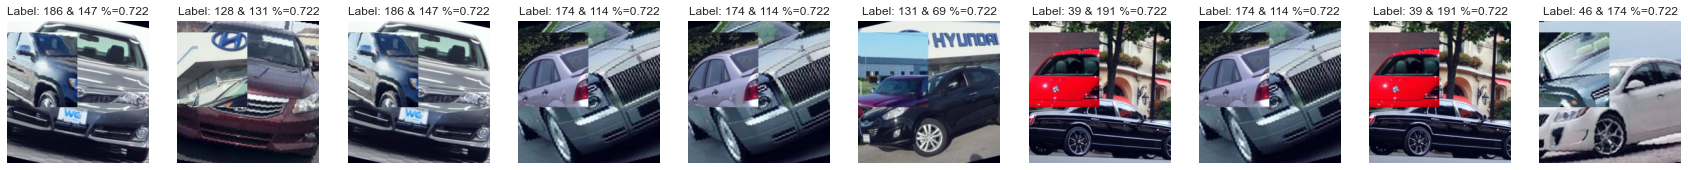

In [5]:
def show_n_samples_from_batch(sample_imgs, sample_labels, n_samples=6):
    """ Plotting n_samples from a batch of images """
    fig, ax = plt.subplots(1,n_samples)
    fig.set_size_inches(3 * n_samples, 3)

    ids = np.random.randint(low=0, high=len(sample_imgs), size=n_samples)

    for i, n in enumerate(ids):
        img = sample_imgs[n]

        # because of normalization of dataset images have strange range, let's fix it with normalization to range [0, 1] for adequate visualization
        img = img.clone().detach()
        img += np.abs(img.min())
        img /= img.max()
        label = f"{str(sample_labels[0][n].numpy())} & {str(sample_labels[1][n].numpy())} %={str(sample_labels[2]):{1}.{5}}"
        ax[i].imshow(img.permute(1,2,0))
        ax[i].set_title(f"Label: {label}")
        ax[i].axis("off")
    plt.show()

train_batch_aug = next(iter(train_loader))
sample_imgs_aug, sample_labels_aug = train_batch_aug

#helpers.show_n_samples_from_batch(sample_imgs, sample_labels, 8)
show_n_samples_from_batch(sample_imgs_aug, sample_labels_aug, 10)

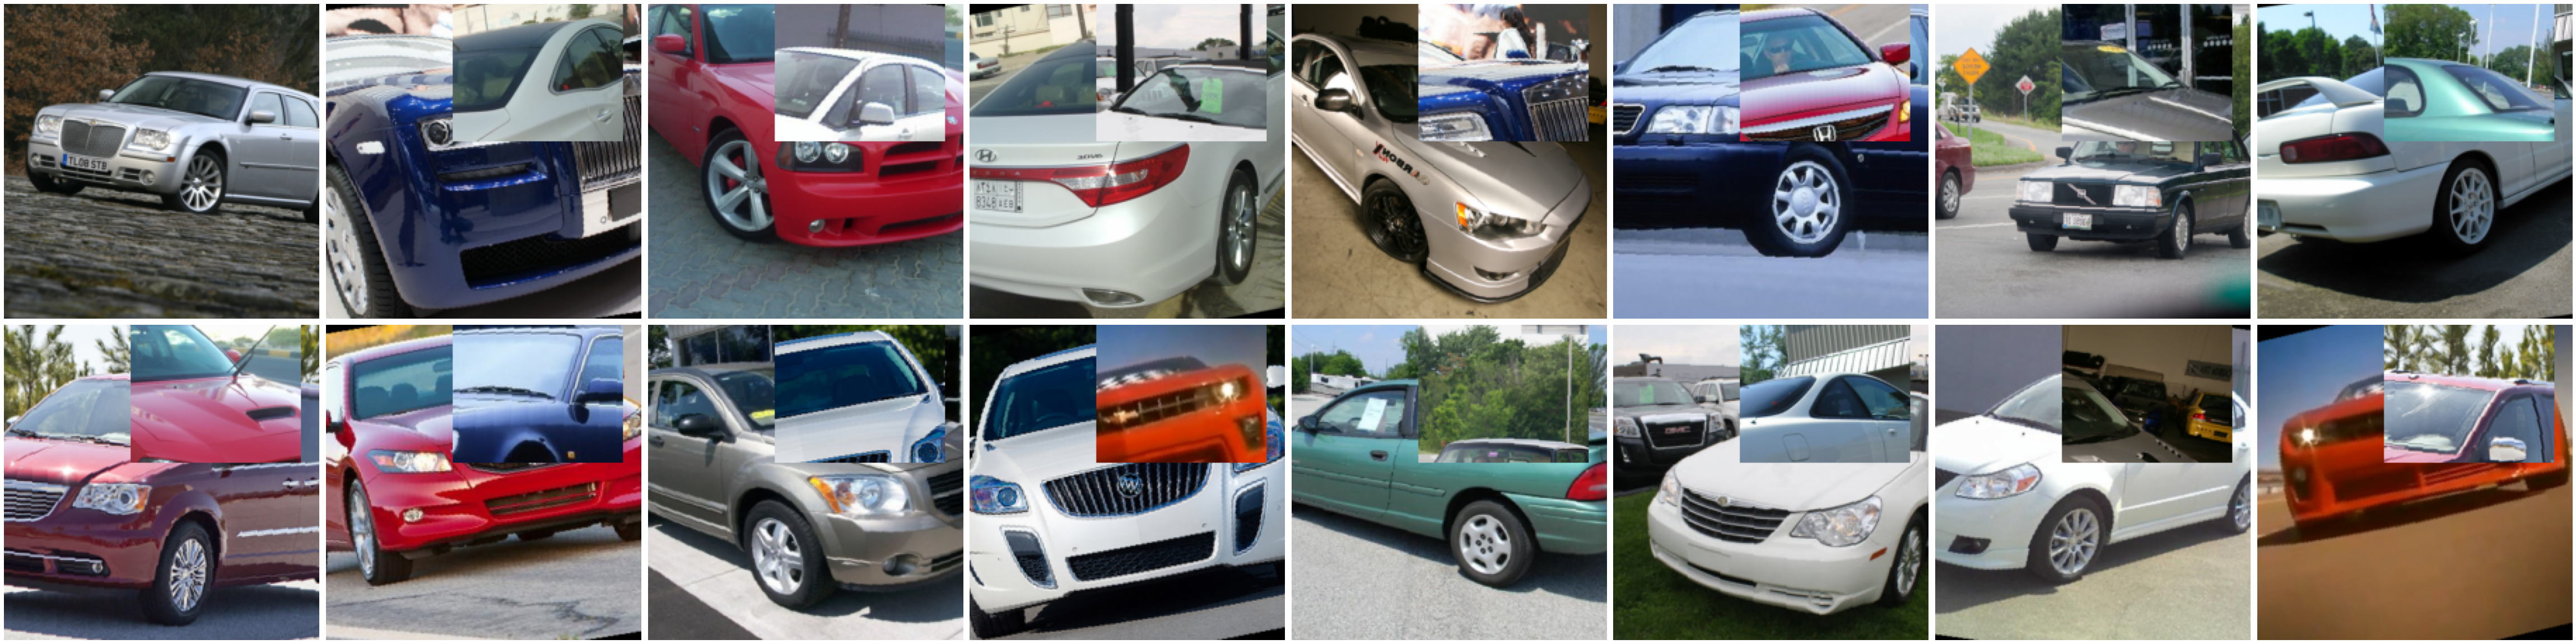

In [6]:
def show_grid(data, titles=None):
    """Imshow for Tensor."""
    data = data.numpy().transpose((0, 2, 3, 1))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    data = std * data + mean
    data = np.clip(data, 0, 1)
    
    plt.figure(figsize=(8*2*4, 4*2*4))
    for i in range(16):
        plt.subplot(4,8,i+1)
        plt.imshow(data[i])
        plt.axis("off")
        if titles is not None:
            plt.set_title("test")
            # plt.title(titles[i])
    plt.tight_layout()
    plt.show()
            
# Get a batch of training data and displaying it
inputs, classes = next(iter(train_loader))
# titles = [class_names[x] for x in classes]

show_grid(inputs)

### **Experiments:** 
#### **Experiments 1:**

In [7]:


def train_epoch(model, train_loader, optimizer, criterion, epoch, device, use_cutmix=False):
    """ Training a model for one epoch """
    
    loss_list = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        # labels = labels.to(device)

        if isinstance(labels, (tuple, list)):
            labels1, labels2, lam = labels
            labels = (labels1.to(device), labels2.to(device), lam)
        else:
            labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)

        if use_cutmix:
            criterion = CutMixCriterion(reduction='mean')
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device):
    """ Evaluating the model for either validation or test """
    correct = 0
    total = 0
    loss_list = []
    
    for images, labels in eval_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    
    return accuracy, loss


def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs, tboard=None, start_epoch=0, use_cutmix=False):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        accuracy, loss = eval_model(
                    model=model, eval_loader=valid_loader,
                    criterion=criterion, device=device
            )
        valid_acc.append(accuracy)
        val_loss.append(loss)
        tboard.add_scalar(f'Accuracy/Valid', accuracy, global_step=epoch+start_epoch)
        tboard.add_scalar(f'Loss/Valid', loss, global_step=epoch+start_epoch)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device, use_cutmix=use_cutmix
            )
        scheduler.step()
        train_loss.append(mean_loss)
        tboard.add_scalar(f'Loss/Train', mean_loss, global_step=epoch+start_epoch)

        loss_iters = loss_iters + cur_loss_iters
        
        if(epoch % 1 == 0 or epoch==num_epochs-1):
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
            print(f"    Accuracy: {accuracy}%")
            print("\n")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, valid_acc

In [8]:
def save_model(model, optimizer, epoch, stats):
    """ Saving model checkpoint """
    
    if(not os.path.exists("models")):
        os.makedirs("models")
    savepath = f"models/checkpoint_epoch_{epoch}.pth"

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, savepath)
    return


def load_model(model, optimizer, savepath):
    """ Loading pretrained checkpoint """
    
    checkpoint = torch.load(savepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint["epoch"]
    stats = checkpoint["stats"]
    
    return model, optimizer, epoch, stats


def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = 13
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return

In [28]:
def add_model_classifier(model, model_name, n_classes, freeze_layers=False):
    """
    Method for adding classifer at the top
    """
    if  freeze_layers:
        for param in model.parameters():
            param.requires_grad = False
    if model_name == "resnet":
        num_logits = model.fc.in_features
        model.fc = nn.Linear(num_logits, n_classes)
    
    elif model_name in ["vgg", "convnext", "swin-t"]:
        num_logits = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_logits, n_classes)
    
    

    return model

def run_experiment(
    model,
    experiments_name,
    train_loader,
    valid_loader,
    num_epochs=15,
    use_scheduler=True,
    use_cutmix=False,
    optimizer=None,
    scheduler=None,
    
):
    # classification loss function
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    else:
        optimizer = optimizer

    if use_scheduler:
        if scheduler is None:
            # Decay LR by a factor of 0.1 every 7 epochs
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        else:
            scheduler = scheduler
    else:
        scheduler = None
    
    log_dir = os.path.join(os.getcwd(), "tboard_logs", experiments_name)
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    writer = SummaryWriter(log_dir)

    train_loss, val_loss, loss_iters, valid_acc = train_model(
        model=model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
        train_loader=train_loader, valid_loader=valid_loader, num_epochs=num_epochs, tboard=writer, start_epoch=0, use_cutmix=use_cutmix
    )

    return train_loss, val_loss, loss_iters, valid_acc


In [10]:
def plot_analysis(loss_iters, train_loss, val_loss, valid_acc, title):
    """
    flag: plot accuracy only
    """
    plt.style.use('seaborn')
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(24,5)
    fig.suptitle(title)
    smooth_loss = smooth(loss_iters, 31)
    ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[0].legend(loc="best")
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("CE Loss")
    ax[0].set_title("Training Progress")

    epochs = np.arange(len(train_loss)) + 1
    ax[1].plot(epochs, train_loss, c="red", label="Train Loss", linewidth=3)
    ax[1].plot(epochs, val_loss, c="blue", label="Valid Loss", linewidth=3)
    ax[1].legend(loc="best")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("CE Loss")
    ax[1].set_title("Loss Curves")
    
    epochs = np.arange(len(val_loss)) + 1
    ax[2].plot(epochs, valid_acc, c="red", label="Valid accuracy", linewidth=3)
    ax[2].legend(loc="best")
    ax[2].set_xlabel("Epochs")
    ax[2].set_ylabel("Accuracy (%)")
    ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc),2)}% @ epoch {np.argmax(valid_acc)+1})")

    plt.show()

In [11]:
set_random_seed()

Fine tune VGG

In [15]:
vgg11 = models.vgg11(pretrained=True)
model_name = "vgg"
n_classes = 196
vgg_model_ft = add_model_classifier(vgg11, model_name, n_classes)
# freeze all layers
for param in vgg_model_ft.features.parameters():
    param.requires_grad = False
# unfreeze last module
for param in vgg_model_ft.classifier.parameters():
    param.requires_grad = True

vgg_model_ft = vgg_model_ft.to(device)

I use VGG only with frozen feature extractor because my GPU is too small ;(

In [16]:
experiments_name = "vgg_feature_extractor"
num_epochs = 15
train_loss_vgg_ft, val_loss_vgg_ft, loss_iters_vgg_ft, valid_acc_vgg_ft = run_experiment(
                                                                                vgg_model_ft,
                                                                                experiments_name,
                                                                                train_loader,
                                                                                eval_loader,
                                                                                num_epochs=num_epochs,
                                                                                use_scheduler=True,
                                                                                use_cutmix=True
                                                                            )

Epoch 1/15
    Train loss: 5.32927
    Valid loss: 5.32773
    Accuracy: 0.3606516602412635%


Epoch 2/15
    Train loss: 5.2985
    Valid loss: 5.27218
    Accuracy: 0.7337395846287775%


Epoch 3/15
    Train loss: 5.20818
    Valid loss: 5.05303
    Accuracy: 1.6415868673050615%


Epoch 4/15
    Train loss: 5.15808
    Valid loss: 4.89368
    Accuracy: 2.4126352443725905%


Epoch 5/15
    Train loss: 5.10827
    Valid loss: 4.82361
    Accuracy: 3.4697176968038796%


Epoch 6/15
    Train loss: 5.06196
    Valid loss: 4.66102
    Accuracy: 4.439746300211417%


Epoch 7/15
    Train loss: 5.01692
    Valid loss: 4.60577
    Accuracy: 6.267877129710235%


Epoch 8/15
    Train loss: 4.91343
    Valid loss: 4.45105
    Accuracy: 6.752891431414003%


Epoch 9/15
    Train loss: 4.88306
    Valid loss: 4.413
    Accuracy: 8.357169506280314%


Epoch 10/15
    Train loss: 4.83434
    Valid loss: 4.38501
    Accuracy: 8.81731127969158%


Epoch 11/15
    Train loss: 4.85672
    Valid loss: 4.3294

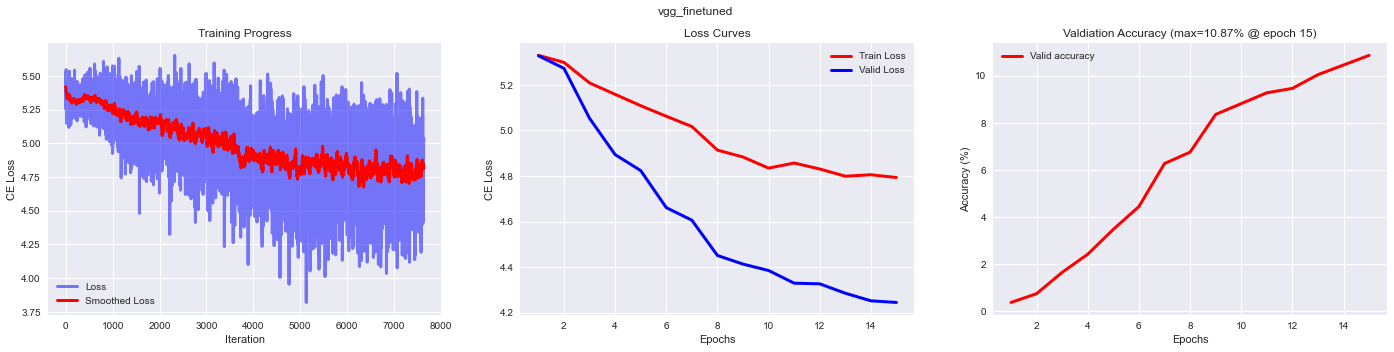

In [17]:
plot_analysis(loss_iters_vgg_ft, train_loss_vgg_ft, val_loss_vgg_ft, valid_acc_vgg_ft, experiments_name)

Performance of VGG with frozen feature extractor is not very good. Only 10.87% after 15 epochs

In [48]:
resnet = models.resnet18(pretrained=True)
model_name = "resnet"
n_classes = 196
resnet_model_ft = add_model_classifier(resnet, model_name, n_classes)
# # freeze all layers
# for param in resnet_model_ft.parameters():
#     param.requires_grad = False
# # unfreeze last layer
# for param in resnet_model_ft.fc.parameters():
#     param.requires_grad = True
resnet_model_ft = resnet_model_ft.to(device)

In [49]:
experiments_name = "resnet_finetuned"
num_epochs = 5
train_loss_resnet_ft, val_loss_resnet_ft, loss_iters_resnet_ft, valid_acc_resnet_ft = run_experiment(
                                                                                        resnet_model_ft,
                                                                                        experiments_name,
                                                                                        train_loader,
                                                                                        eval_loader,
                                                                                        num_epochs=num_epochs,
                                                                                        use_scheduler=True,
                                                                                        use_cutmix=True
                                                                                    )

Epoch 1/15
    Train loss: 4.98672
    Valid loss: 5.48983
    Accuracy: 0.6342494714587738%


Epoch 2/15
    Train loss: 4.28
    Valid loss: 3.80926
    Accuracy: 14.028105956970528%




KeyboardInterrupt: 

The following plot represents the results of training of ResNet with frozen feature extractor. Results of training without freezing are in tensorBoard

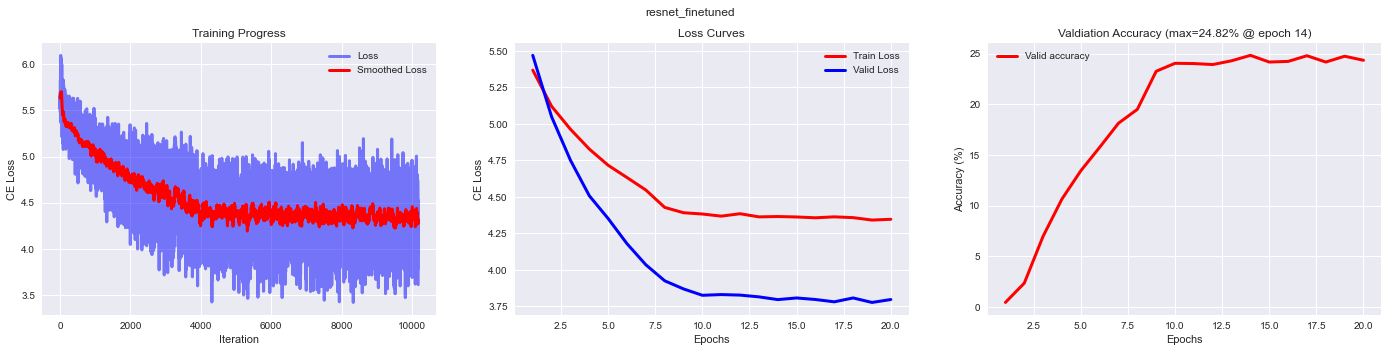

In [50]:
plot_analysis(loss_iters_resnet_ft, train_loss_resnet_ft, val_loss_resnet_ft, valid_acc_resnet_ft, experiments_name)


In [45]:
convnext = models.convnext_small(pretrained=True)
model_name = "convnext"
n_classes = 196
convnext_model_ft = add_model_classifier(convnext, model_name, n_classes)
# # freeze all layers
# for param in convnext_model_ft.parameters():
#     param.requires_grad = False
# # unfreeze last layer
# for param in convnext_model_ft.fc.parameters():
#     param.requires_grad = True
convnext_model_ft = convnext_model_ft.to(device)

In [46]:
experiments_name = "convnext_finetuned"
num_epochs = 20
train_loss_convnext_ft, val_loss_convnext_ft, loss_iters_convnext_ft, valid_acc_convnext_ft = run_experiment(
                                                                                        convnext_model_ft,
                                                                                        experiments_name,
                                                                                        train_loader,
                                                                                        eval_loader,
                                                                                        num_epochs=num_epochs,
                                                                                        use_scheduler=True,
                                                                                        use_cutmix=True
                                                                                    )

Epoch 1/20
    Train loss: 5.29697
    Valid loss: 5.31021
    Accuracy: 0.6839945280437756%


Epoch 2/20
    Train loss: 5.28831
    Valid loss: 5.2788
    Accuracy: 0.53475935828877%


Epoch 3/20
    Train loss: 5.29345
    Valid loss: 5.2778
    Accuracy: 0.8456659619450317%


Epoch 4/20
    Train loss: 5.29033
    Valid loss: 5.28616
    Accuracy: 0.8456659619450317%


Epoch 5/20
    Train loss: 5.28474
    Valid loss: 5.27878
    Accuracy: 0.8456659619450317%




KeyboardInterrupt: 

Ok, training of the pretrained feature extractor and not trained classifier of ConvNext performs very bad (at least in my case)

The next plot shows the performance of training of convnext with frozen Feature extractor



Let's test Swin-T Transformer

In [33]:
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss
from warmup_scheduler import GradualWarmupScheduler 

In [34]:
HUB_URL = "SharanSMenon/swin-transformer-hub:main"
MODEL_NAME = "swin_tiny_patch4_window7_224"
# check hubconf for more models.
SWIN_T_model = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True) # load from torch hub



Using cache found in C:\Users\schel/.cache\torch\hub\SharanSMenon_swin-transformer-hub_main


In [35]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")



In [36]:

for param in SWIN_T_model.parameters(): #freeze model
    param.requires_grad = False
# we will train only the head
n_inputs = SWIN_T_model.head.in_features
SWIN_T_model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 196)
)
SWIN_T_model = SWIN_T_model.to(device)

In [37]:
criterion_swin = LabelSmoothingCrossEntropy()
criterion_swin = criterion_swin.to(device)
optimizer_swin = torch.optim.AdamW(SWIN_T_model.head.parameters(), lr=0.001)
# Decay LR by a factor of 0.9 every 4 epochs
scheduler_swin = torch.optim.lr_scheduler.StepLR(optimizer_swin, step_size=4, gamma=0.9)

In [38]:
TBOARD_LOGS_SWIN_T = os.path.join(os.getcwd(), "tboard_logs", "swin_T_finetuning")
if not os.path.exists(TBOARD_LOGS_SWIN_T):
    os.makedirs(TBOARD_LOGS_SWIN_T)

shutil.rmtree(TBOARD_LOGS_SWIN_T)
writer_swin_t = SummaryWriter(TBOARD_LOGS_SWIN_T)

In [39]:
train_loss_swin, val_loss_swin, loss_iters_swin, valid_acc_swin = train_model(
        model=SWIN_T_model, optimizer=optimizer_swin, scheduler=scheduler_swin, criterion=criterion_swin,
        train_loader=train_loader, valid_loader=eval_loader, num_epochs=20, tboard=writer_swin_t, use_cutmix=True
    )

Epoch 1/20
    Train loss: 4.93302
    Valid loss: 5.28649
    Accuracy: 0.34821539609501306%


Epoch 2/20
    Train loss: 4.56252
    Valid loss: 4.14985
    Accuracy: 11.49110807113543%


Epoch 3/20
    Train loss: 4.38516
    Valid loss: 3.77994
    Accuracy: 18.38079840815819%


Epoch 4/20
    Train loss: 4.27479
    Valid loss: 3.62745
    Accuracy: 20.79343365253078%


Epoch 5/20
    Train loss: 4.17828
    Valid loss: 3.49018
    Accuracy: 25.54408655639846%


Epoch 6/20
    Train loss: 4.11967
    Valid loss: 3.38335
    Accuracy: 28.23031961198856%


Epoch 7/20
    Train loss: 4.08307
    Valid loss: 3.28502
    Accuracy: 29.374455913443605%


Epoch 8/20
    Train loss: 4.01251
    Valid loss: 3.23223
    Accuracy: 31.73734610123119%


Epoch 9/20
    Train loss: 3.91066
    Valid loss: 3.13358
    Accuracy: 34.34896157194379%


Epoch 10/20
    Train loss: 3.91322
    Valid loss: 3.08665
    Accuracy: 35.64233304315383%


Epoch 11/20
    Train loss: 3.89622
    Valid loss: 3.00

Swin-T with frozen feature_extractor performs much better than other convolutional networks

* Compare the following: Fine-Tuned ResNet, ResNet as fixed feature extractor, and ResNet with a Combined Approach

In [53]:
resnet_1 = None
resnet_1 = models.resnet18(pretrained=True)
model_name = "resnet"
n_classes = 196
resnet_1_model_ft = add_model_classifier(resnet_1, model_name, n_classes)
# freeze all layers
for param in resnet_1_model_ft.parameters():
    param.requires_grad = False
# unfreeze last layer
for param in resnet_1_model_ft.fc.parameters():
    param.requires_grad = True
resnet_1_model_ft = resnet_1_model_ft.to(device)

In [54]:
experiments_name = "resnet_feature_extractor"
num_epochs = 10
train_loss_resnet_1_ft, val_loss_resnet_1_ft, loss_iters_resnet_1_ft, valid_acc_resnet_1_ft = run_experiment(
                                                                                        resnet_1_model_ft,
                                                                                        experiments_name,
                                                                                        train_loader,
                                                                                        eval_loader,
                                                                                        num_epochs=num_epochs,
                                                                                        use_scheduler=True,
                                                                                        use_cutmix=True
                                                                                    )

Epoch 1/10
    Train loss: 5.37928
    Valid loss: 5.47471
    Accuracy: 0.5098868299962691%


Epoch 2/10
    Train loss: 5.12943
    Valid loss: 5.04881
    Accuracy: 3.3080462629026237%


Epoch 3/10
    Train loss: 4.96516
    Valid loss: 4.75182
    Accuracy: 6.566347469220246%


Epoch 4/10
    Train loss: 4.84456
    Valid loss: 4.52906
    Accuracy: 9.86195746797662%


Epoch 5/10
    Train loss: 4.70884
    Valid loss: 4.33883
    Accuracy: 13.555527919413008%


Epoch 6/10
    Train loss: 4.62986
    Valid loss: 4.20711
    Accuracy: 14.239522447456784%


Epoch 7/10
    Train loss: 4.55854
    Valid loss: 4.08771
    Accuracy: 15.508021390374333%


Epoch 8/10
    Train loss: 4.41978
    Valid loss: 3.94094
    Accuracy: 18.455415993035693%


Epoch 9/10
    Train loss: 4.395
    Valid loss: 3.87655
    Accuracy: 22.049496331302077%


Epoch 10/10
    Train loss: 4.40114
    Valid loss: 3.8583
    Accuracy: 22.559383161298346%


Training completed


Let's unfreeze the feature extractor and continue to train the network

In [55]:
# unfreeze all layers
for param in resnet_1_model_ft.parameters():
    param.requires_grad = True

In [56]:
experiments_name = "resnet_combined"
num_epochs = 10
train_loss_resnet_1_ft, val_loss_resnet_1_ft, loss_iters_resnet_1_ft, valid_acc_resnet_1_ft = run_experiment(
                                                                                        resnet_1_model_ft,
                                                                                        experiments_name,
                                                                                        train_loader,
                                                                                        eval_loader,
                                                                                        num_epochs=num_epochs,
                                                                                        use_scheduler=True,
                                                                                        use_cutmix=True
                                                                                    )

Epoch 1/10
    Train loss: 4.31002
    Valid loss: 3.85158
    Accuracy: 22.29822161422709%


Epoch 2/10
    Train loss: 3.77457
    Valid loss: 2.8078
    Accuracy: 32.37159557268996%


Epoch 3/10
    Train loss: 3.47241
    Valid loss: 2.0392
    Accuracy: 50.10570824524313%


Epoch 4/10
    Train loss: 3.25886
    Valid loss: 1.7356
    Accuracy: 57.95299092152717%


Epoch 5/10
    Train loss: 3.09624
    Valid loss: 1.44897
    Accuracy: 66.26041537122248%


Epoch 6/10
    Train loss: 3.01321
    Valid loss: 1.31577
    Accuracy: 68.94664842681259%


Epoch 7/10
    Train loss: 2.83731
    Valid loss: 1.25809
    Accuracy: 69.09588359656759%


Epoch 8/10
    Train loss: 2.6338
    Valid loss: 1.12627
    Accuracy: 72.41636612361646%


Epoch 9/10
    Train loss: 2.51011
    Valid loss: 0.87556
    Accuracy: 79.26874766820046%


Epoch 10/10
    Train loss: 2.47271
    Valid loss: 0.83943
    Accuracy: 80.38801144136302%


Training completed


Combined approach performs not much better than finetunnig of the unfrozen ResNet

## Experiment 2

Try to get the best performance possible on this dataset
 - Fine-tune a pretrained neural network of your choice for classification.
 - Select a good training recipe: augmentations, optimizer, learning rate scheduling, classifier, loss function

My idea is to fine tune the ConvNext network with combined approach

According to this article: https://medium.com/augmented-startups/convnext-the-return-of-convolution-networks-e70cbe8dabcc
ConvNext performs even better than Swin-T 

In [63]:

convnext_ex2 = models.convnext_small(pretrained=True)
model_name = "convnext"
n_classes = 196
convnext_model_ex2 = add_model_classifier(convnext_ex2, model_name, n_classes)
# freeze all layers
for param in convnext_model_ex2.parameters():
    param.requires_grad = False
# unfreeze last layer
for param in convnext_model_ex2.classifier.parameters():
    param.requires_grad = True
convnext_ex2 = convnext_ex2.to(device)

In [64]:
experiments_name = "convnext_ex2_1"
num_epochs = 5
train_loss_convnext_ex2_1, val_loss_convnext_ex2_1, loss_iters_convnext_ex2_1, valid_acc_convnext_ex2_1 = run_experiment(
                                                                                        convnext_model_ex2,
                                                                                        experiments_name,
                                                                                        train_loader,
                                                                                        eval_loader,
                                                                                        num_epochs=num_epochs,
                                                                                        use_scheduler=True,
                                                                                        use_cutmix=True
                                                                                    )

Epoch 1/5
    Train loss: 4.97714
    Valid loss: 5.32983
    Accuracy: 0.5471956224350205%


Epoch 2/5
    Train loss: 4.50353
    Valid loss: 4.078
    Accuracy: 13.120258674294242%


Epoch 3/5
    Train loss: 4.23999
    Valid loss: 3.55126
    Accuracy: 21.999751274717074%


Epoch 4/5
    Train loss: 4.0705
    Valid loss: 3.2359
    Accuracy: 26.228081084442234%


Epoch 5/5
    Train loss: 3.91993
    Valid loss: 3.02248
    Accuracy: 30.033577913194875%


Training completed


Ok, "frozen" Convnext performs better than all other "frozen" networks

Let's train the whole network

In [65]:
# unfreeze all layers
for param in convnext_model_ex2.parameters():
    param.requires_grad = True

experiments_name = "convnext_ex2_2"
num_epochs = 5
train_loss_convnext_ex2_2, val_loss_convnext_ex2_2, loss_iters_convnext_ex2_2, valid_acc_convnext_ex2_2 = run_experiment(
                                                                                        convnext_model_ex2,
                                                                                        experiments_name,
                                                                                        train_loader,
                                                                                        eval_loader,
                                                                                        num_epochs=num_epochs,
                                                                                        use_scheduler=True,
                                                                                        use_cutmix=True
                                                                                    )

Epoch 1/5
    Train loss: 3.51714
    Valid loss: 2.86143
    Accuracy: 32.07312523317996%


Epoch 2/5
    Train loss: 2.80726
    Valid loss: 1.32199
    Accuracy: 67.03146374829001%


Epoch 3/5
    Train loss: 2.46673
    Valid loss: 0.89238
    Accuracy: 76.95560253699789%


Epoch 4/5
    Train loss: 2.26022
    Valid loss: 0.78016
    Accuracy: 80.37557517721676%


Epoch 5/5
    Train loss: 2.16276
    Valid loss: 0.58817
    Accuracy: 84.1064544210919%


Training completed


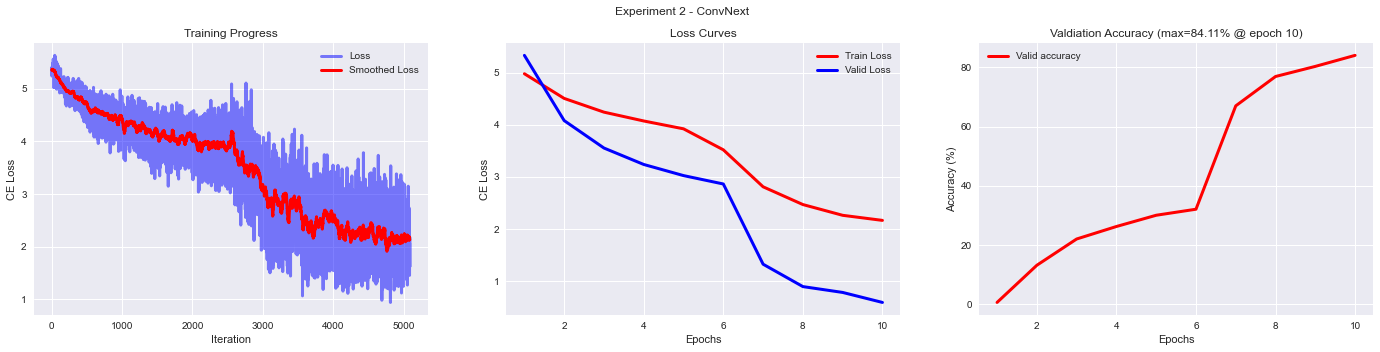

In [66]:
train_loss_convnext_ex2 = train_loss_convnext_ex2_1 + train_loss_convnext_ex2_2
val_loss_convnext_ex2 = val_loss_convnext_ex2_1 + val_loss_convnext_ex2_2
loss_iters_convnext_ex2 = loss_iters_convnext_ex2_1 + loss_iters_convnext_ex2_2
valid_acc_convnext_ex2 = valid_acc_convnext_ex2_1 + valid_acc_convnext_ex2_2

plot_analysis(loss_iters_convnext_ex2, train_loss_convnext_ex2, val_loss_convnext_ex2, valid_acc_convnext_ex2, "Experiment 2 - ConvNext")

After 5 epochs of finetuning the network has 84.11% of accuracy on test data. 


Description of the plots in tensorBoards:

- All the labels with "_finetuned" were trained without "freezing"
- All the labels with "_feature_extractor" were trained with "frozen" feature extractor
- "_ex2_*" shows the results of 2nd experiment
- "_combined" means that the feature extractor of the network was first "frozen" and in the current training is used without it